In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = 'mps' if torch.backends.mps.is_available() else (
    'cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")

Using device = mps


In [2]:
def get_image(path, img_transform, size = (300,300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t())
    return m

def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

![figure](https://user-images.githubusercontent.com/30661597/107026142-96fa0100-67aa-11eb-9f71-4adce01dd362.png)

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained=True).features

    def forward(self, x):
        layer_features = []
        for layer_number, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
        return layer_features

In [5]:
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

content_img = get_image('a.JPG', img_transform)
style_img = get_image('Edvard_Munch,_1893.jpg', img_transform)
generated_img = content_img.clone()    # or nn.Parameter(torch.FloatTensor(content_img.size()))
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

for p in encoder.parameters():
    p.requires_grad = False

/Users/saalikmubeen/Dev/Machine Learning/cs7643/dl-final-project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/saalikmubeen/Dev/Machine Learning/cs7643/dl-final-project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/saalikmubeen/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [03:19<00:00, 2.77MB/s] 


In [6]:
content_weight = 1
style_weight = 100

for epoch in range(500):

    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)

    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w)

    loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))

Epoch [0]	Content Loss: 0.0000	Style Loss: 232.5505
Epoch [10]	Content Loss: 0.7528	Style Loss: 149.9196
Epoch [20]	Content Loss: 1.0667	Style Loss: 98.9827
Epoch [30]	Content Loss: 1.2012	Style Loss: 71.4850
Epoch [40]	Content Loss: 1.2805	Style Loss: 55.3475
Epoch [50]	Content Loss: 1.3391	Style Loss: 44.6055
Epoch [60]	Content Loss: 1.3892	Style Loss: 36.9863
Epoch [70]	Content Loss: 1.4315	Style Loss: 31.3791
Epoch [80]	Content Loss: 1.4632	Style Loss: 27.1080
Epoch [90]	Content Loss: 1.4889	Style Loss: 23.7560
Epoch [100]	Content Loss: 1.5093	Style Loss: 21.0520
Epoch [110]	Content Loss: 1.5302	Style Loss: 18.8312
Epoch [120]	Content Loss: 1.5489	Style Loss: 16.9769
Epoch [130]	Content Loss: 1.5659	Style Loss: 15.4163
Epoch [140]	Content Loss: 1.5811	Style Loss: 14.0949
Epoch [150]	Content Loss: 1.5949	Style Loss: 12.9667
Epoch [160]	Content Loss: 1.6076	Style Loss: 11.9967
Epoch [170]	Content Loss: 1.6201	Style Loss: 11.1543
Epoch [180]	Content Loss: 1.6320	Style Loss: 10.4218
Ep

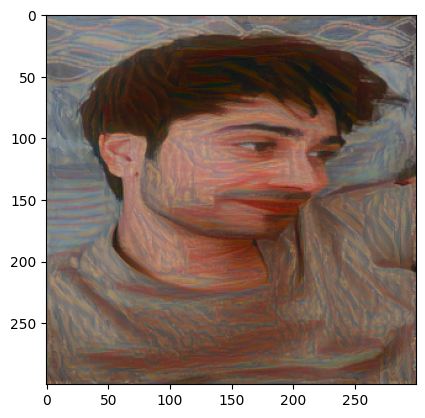

In [7]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)